<a href="https://colab.research.google.com/github/kusawokoshitemori/gan_colab/blob/main/anime_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q kaggle kagglehub
!pip install -q matplotlib # 画像表示用

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# 1. kaggle.jsonファイルをアップロード
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# 2. アップロードされたファイルを適切な場所に移動し、パーミッションを設定
#    Colabのランタイムがリセットされるたびに必要です。
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API key configured.")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API key configured.


In [3]:
import kagglehub
import os

# データセットのダウンロード
# "splcher/animefacedataset" はKaggleのデータセットのIDです
print("Downloading Anime Face Dataset...")
# kagglehub.dataset_download は通常、既に解凍されたデータが含まれるディレクトリのパスを返します
DATA_DIR = kagglehub.dataset_download("splcher/animefacedataset")
print(f"Dataset downloaded and located at: {DATA_DIR}")

Dataset downloaded and located at: /kaggle/input/animefacedataset


Using IMAGE_FILES_DIR: /kaggle/input/animefacedataset/images
Attempting to display: /kaggle/input/animefacedataset/images/35715_2011.jpg


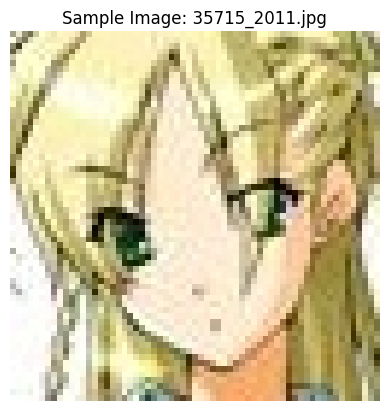


Image displayed successfully!


In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import os

# 既に定義されている場合はその値を使用
IMAGE_FILES_DIR = os.path.join(DATA_DIR, 'images')
print(f"Using IMAGE_FILES_DIR: {IMAGE_FILES_DIR}")

# 画像ファイルが実際に存在するか確認
if not os.path.exists(IMAGE_FILES_DIR):
    print(f"Error: Image directory not found at {IMAGE_FILES_DIR}. Please check the path.")
elif not os.listdir(IMAGE_FILES_DIR):
    print(f"Error: Image directory {IMAGE_FILES_DIR} is empty. No images to display.")
else:
    # ディレクトリ内の最初の画像ファイルを取得
    first_image_filename = os.listdir(IMAGE_FILES_DIR)[0]
    first_image_path = os.path.join(IMAGE_FILES_DIR, first_image_filename)

    print(f"Attempting to display: {first_image_path}")

    try:
        # 画像をPIL形式で開く
        img = Image.open(first_image_path).convert('RGB') # 確実にRGBとして開く

        # 画像を表示
        plt.imshow(img)
        plt.title(f"Sample Image: {first_image_filename}")
        plt.axis('off') # 軸を非表示にする
        plt.show()

        print("\nImage displayed successfully!")

    except Exception as e:
        print(f"An error occurred while displaying the image: {e}")
        print("Please ensure the image file is not corrupted and is a valid image format.")

Found 63565 images in /kaggle/input/animefacedataset/images
Batch shape: torch.Size([128, 3, 64, 64])


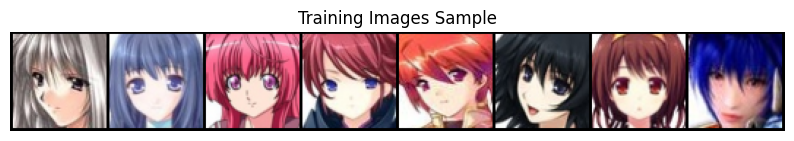

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os # <-- osモジュールをインポートしていなければ、ここで追加します

# ハイパーパラメータの設定 (後で調整可能)
IMAGE_SIZE = 64 # 生成する画像のサイズ (64x64ピクセル)
BATCH_SIZE = 128 # 1バッチあたりの画像数
NUM_WORKERS = 2 # データローダーがデータを読み込むための並列プロセス数 (Colabでは通常2か4)

# 画像の前処理 (Transforms)
# DCGANでは通常[-1, 1]の範囲に正規化します
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),       # 指定サイズにリサイズ
    transforms.CenterCrop(IMAGE_SIZE),   # 中央でクロップ
    transforms.ToTensor(),               # PIL ImageをPyTorch Tensorに変換 ([0, 1]の範囲)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # [-1, 1]に正規化
])

# カスタムデータセットクラス (Kaggleのデータセットは多くの場合サブフォルダがないので、ImageFolderは直接使えない)
class AnimeFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        # root_dir直下の画像ファイルを探す
        for fname in os.listdir(root_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(root_dir, fname))
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB') # 確実にRGBに変換
        if self.transform:
            image = self.transform(image)
        return image

# データセットのインスタンス化
# ここを修正します！
# DATA_DIRはKaggleHubダウンロードで得られたルートパス。
# 実際の画像は DATA_DIR の中の 'images' フォルダにあります。
# まず、正しい画像ディレクトリのパスを構築します。
# DATA_DIRがこのセルでまだ定義されていない場合は、前のセル（Kaggleデータセットダウンロード）を先に実行してください。
global DATA_DIR # <-- DATA_DIRがColabセッション全体で利用可能であることを確認
if 'DATA_DIR' not in globals():
    print("Warning: DATA_DIR not found. Assuming default Kaggle path. Please run the data download cell first.")
    DATA_DIR = '/kaggle/input/animefacedataset' # フォールバック

IMAGE_FILES_DIRECTORY = os.path.join(DATA_DIR, 'images') # ★この行を追加・修正します

# AnimeFaceDatasetに、画像が格納されている正しいディレクトリを渡します。
dataset = AnimeFaceDataset(root_dir=IMAGE_FILES_DIRECTORY, transform=transform) # ★この行を修正します

# データローダーの作成
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# データローダーからバッチを一つ取得して確認 (オプション)
if dataloader:
    for images in dataloader:
        print(f"Batch shape: {images.shape}") # (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)となるはず
        # 最初の8枚を表示
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.title("Training Images Sample")
        # 画像の表示には permute(1, 2, 0) が必要 (PyTorch: C H W -> Matplotlib: H W C)
        plt.imshow(torchvision.utils.make_grid(images[:8], padding=2, normalize=True).permute(1, 2, 0))
        plt.show()
        break
else:
    print("Dataloader not created. Check IMAGE_FILES_DIRECTORY path or dataset content.")

In [6]:
import torch.nn as nn

# ハイパーパラメータの設定
LATENT_DIM = 100 # ジェネレーターの入力ノイズの次元数 (Z-vectorの次元)
NGF = 64 # Generatorの最初の特徴マップ数
NDF = 64 # Discriminatorの最初の特徴マップ数
NUM_CHANNELS = 3 # 画像のチャンネル数 (RGBなので3)

# CUDAが利用可能かチェック (GPUを使用する場合)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generator (生成器)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 入力: Z (潜在ベクトル) は (LATENT_DIM, 1, 1) として扱われる
            nn.ConvTranspose2d(LATENT_DIM, NGF * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NGF * 8),
            nn.ReLU(True),
            # 状態サイズ: (NGF*8) x 4 x 4
            nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 4),
            nn.ReLU(True),
            # 状態サイズ: (NGF*4) x 8 x 8
            nn.ConvTranspose2d(NGF * 4, NGF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 2),
            nn.ReLU(True),
            # 状態サイズ: (NGF*2) x 16 x 16
            nn.ConvTranspose2d(NGF * 2, NGF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF),
            nn.ReLU(True),
            # 状態サイズ: (NGF) x 32 x 32
            nn.ConvTranspose2d(NGF, NUM_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh() # 出力は [-1, 1] の範囲に正規化された画像
            # 状態サイズ: (NUM_CHANNELS) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Discriminator (識別器)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 入力: (NUM_CHANNELS) x 64 x 64
            nn.Conv2d(NUM_CHANNELS, NDF, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 状態サイズ: (NDF) x 32 x 32
            nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 状態サイズ: (NDF*2) x 16 x 16
            nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 状態サイズ: (NDF*4) x 8 x 8
            nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 状態サイズ: (NDF*8) x 4 x 4
            nn.Conv2d(NDF * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() # 出力は [0, 1] の範囲で真偽を判定
            # 状態サイズ: (1) x 1 x 1
        )

    def forward(self, input):
        return self.main(input)

# モデルのインスタンス化とデバイスへの転送
netG = Generator().to(device)
netD = Discriminator().to(device)

# 重みの初期化 (GANでは重要)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

print(netG)
print(netD)

Using device: cuda
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

In [7]:
import torch.optim as optim

# ハイパーパラメータの設定
LEARNING_RATE_G = 0.0002 # Generatorの学習率
LEARNING_RATE_D = 0.0002 # Discriminatorの学習率
BETA1 = 0.5 # Adam optimizerのβ1パラメータ

# 損失関数 (Binary Cross Entropy)
criterion = nn.BCELoss()

# 潜在空間の固定ノイズ (学習の進捗確認用)
fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=device)

# 最適化器
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE_G, betas=(BETA1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE_D, betas=(BETA1, 0.999))

In [ ]:
from torchvision.utils import save_image

NUM_EPOCHS = 50 # 訓練エポック数 (最初は少なめで試すのが良い)
SAVE_DIR_GENERATED_IMAGES = './generated_images' # 生成画像を保存するディレクトリ
os.makedirs(SAVE_DIR_GENERATED_IMAGES, exist_ok=True)
SAVE_INTERVAL = 1 # 5エポックごとに画像を保存

print("Starting Training Loop...")
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(dataloader, 0):
        # (1) Discriminatorの訓練: 実画像でDを更新
        netD.zero_grad()
        real_images = data.to(device)
        b_size = real_images.size(0)
        label_real = torch.full((b_size,), 1.0, dtype=torch.float, device=device) # 実画像はラベル1

        output_real = netD(real_images).view(-1)
        errD_real = criterion(output_real, label_real)
        errD_real.backward() # 誤差逆伝播

        # (1b) Discriminatorの訓練: 偽画像でDを更新
        noise = torch.randn(b_size, LATENT_DIM, 1, 1, device=device)
        fake_images = netG(noise) # Generatorで偽画像を生成
        label_fake = torch.full((b_size,), 0.0, dtype=torch.float, device=device) # 偽画像はラベル0

        # detach()でGeneratorの勾配計算を停止し、Discriminatorのみを訓練
        output_fake = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward() # 誤差逆伝播

        errD = errD_real + errD_fake # Dの全体誤差
        optimizerD.step() # Dのパラメータを更新

        # (2) Generatorの訓練: Dが「偽」を「真」と誤認識するようにGを更新
        netG.zero_grad()
        label_real_for_G = torch.full((b_size,), 1.0, dtype=torch.float, device=device) # Gは偽画像を本物とDに誤認させたいのでラベル1
        output_fake_for_G = netD(fake_images).view(-1) # 先ほど生成した偽画像を使う
        errG = criterion(output_fake_for_G, label_real_for_G)
        errG.backward() # 誤差逆伝播
        optimizerG.step() # Gのパラメータを更新

        # 進捗の表示
        if i % 50 == 0: # 50バッチごとに表示
            print(f'[{epoch}/{NUM_EPOCHS}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {output_real.mean().item():.4f} D(G(z)): {output_fake.mean().item():.4f}')

    # エポックごとに画像を生成して保存 (Nエポックに1回)
    if (epoch + 1) % SAVE_INTERVAL == 0:
        with torch.no_grad(): # 勾配計算をしない
            generated_samples = netG(fixed_noise).cpu()
            # 正規化を解除して [-1, 1] から [0, 1] に戻してから保存 (normalize=Trueで自動的に行われる)
            save_image(generated_samples, os.path.join(SAVE_DIR_GENERATED_IMAGES, f'epoch_{epoch+1:03d}.png'), nrow=8, normalize=True)
            print(f"Saved generated images for epoch {epoch+1}")

print("Training finished!")

Starting Training Loop...
[0/50][0/497] Loss_D: 0.7159 Loss_G: 3.4075 D(x): 0.6781 D(G(z)): 0.1062
[0/50][50/497] Loss_D: 0.4844 Loss_G: 5.4961 D(x): 0.8713 D(G(z)): 0.2439
[0/50][100/497] Loss_D: 1.6289 Loss_G: 10.8383 D(x): 0.9813 D(G(z)): 0.7303
[0/50][150/497] Loss_D: 0.5498 Loss_G: 6.6494 D(x): 0.8514 D(G(z)): 0.2792
[0/50][200/497] Loss_D: 1.2280 Loss_G: 11.1368 D(x): 0.9226 D(G(z)): 0.6010
[0/50][250/497] Loss_D: 0.4613 Loss_G: 5.3910 D(x): 0.8118 D(G(z)): 0.1683
[0/50][300/497] Loss_D: 0.3443 Loss_G: 6.1419 D(x): 0.8012 D(G(z)): 0.0415
[0/50][350/497] Loss_D: 0.4132 Loss_G: 4.3162 D(x): 0.8156 D(G(z)): 0.1418
[0/50][400/497] Loss_D: 0.7969 Loss_G: 9.5233 D(x): 0.9320 D(G(z)): 0.4439
[0/50][450/497] Loss_D: 0.6667 Loss_G: 3.4599 D(x): 0.6208 D(G(z)): 0.0586
Saved generated images for epoch 1
[1/50][0/497] Loss_D: 0.7139 Loss_G: 9.3964 D(x): 0.9203 D(G(z)): 0.4182
[1/50][50/497] Loss_D: 0.3878 Loss_G: 5.4581 D(x): 0.8301 D(G(z)): 0.1429
[1/50][100/497] Loss_D: 0.3252 Loss_G: 3.93

In [ ]:
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

# 生成画像ディレクトリの確認
print(f"Checking generated images in: {SAVE_DIR_GENERATED_IMAGES}")
generated_files = sorted(glob.glob(os.path.join(SAVE_DIR_GENERATED_IMAGES, '*.png')))

if generated_files:
    print("Found generated image files. Displaying the last few:")
    for img_path in generated_files[-3:]: # 最新の3つの画像を例として表示
        print(f"Loading: {img_path}")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
        plt.show()
else:
    print("No generated images found. Please check the SAVE_DIR_GENERATED_IMAGES path and training process.")